Code: make profile determine by the following curves in 2D

The values in the 2D plane should be in x ∈ [-3.141592653589793, 3.141592653589793] and y ∈ [-1.0, 1.0]


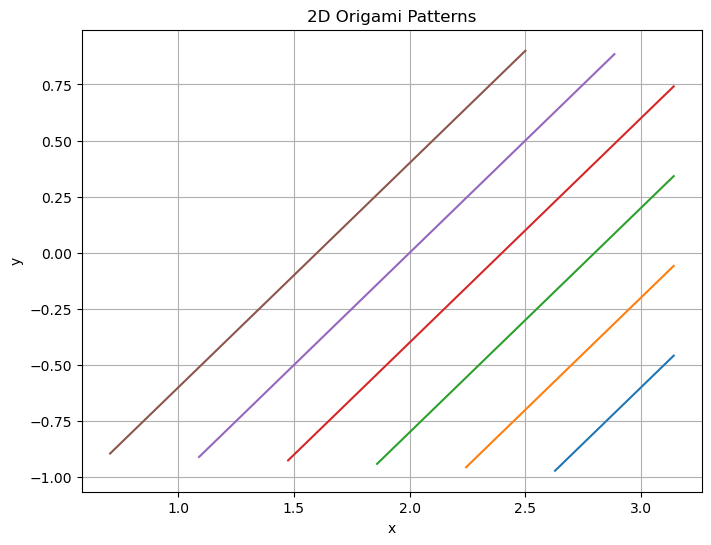

In [ ]:
# Re-import necessary libraries after code execution state reset
import numpy as np
import matplotlib.pyplot as plt

# Cylinder of radius and height 
cylinder_height = 2
cylinder_radius = 1

# Flattened cylinder dimensions
fc_x = cylinder_radius * 2 * np.pi
fc_y = cylinder_height

# Based on the dimensions of the cylinder. We can obtain the dimensions after unrolling the cylinder. This dimensions
# will be used to get the max dimensions of the lines and curves we want to project on this cylinder 
fc_x_min = -fc_x / 2
fc_x_max = fc_x / 2
fc_y_min = -fc_y / 2
fc_y_max = fc_y / 2


# We want to draw a couple of curves on the plane that we will project on the cylinder 
a = 1 # coefficent for the linear equation. 
num_points = 50 # number of points per curves / lines 
num_curves = 6 # number of curves / lines 
point_list = [] # list that stores all the points of each curves 
increment = 0.4 # increment variable for the offset of the linear curve 
b = -4 # starting offset for the linear curve 

# For loop to draw line by lines all the curves 
for i in range(num_curves): 
    b += increment
    x = np.linspace(fc_x_min, fc_x_max, num_points)
    y = a * x + b
    mask = (x >= fc_x_min) & (x <= fc_x_max) & (y >= fc_y_min) & (y <= fc_y_max) # apply a mask to make sure the curves are withing the range of the cylinder 
    point_list.append((x[mask], y[mask])) # append each group of points representing a curve to the point list 

# Plot the curves on the x, y plane. You can imagine this plane as tangeant to a cylinder
plt.figure(figsize=(8, 6))
# for each cluster of points in the point_list plot each points
for x_vals, y_vals in point_list:
    plt.plot(x_vals, y_vals) 
plt.grid(True)
plt.title('2D Origami Patterns')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

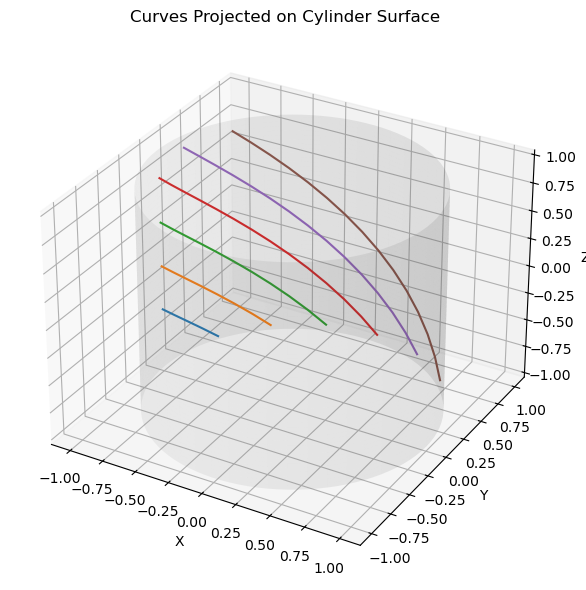

In [2]:

# Re-import necessary libraries after code execution state reset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

point_list_cylinder = [] # this list stores the projected 2D points on the cylinder 

for x_vals, y_vals in point_list:
    theta = x_vals / cylinder_radius  # map x to angle
    X = cylinder_radius * np.cos(theta)
    Y = cylinder_radius * np.sin(theta)
    Z = y_vals  # y becomes height on the cylinder

    point_list_cylinder.append((X, Y, Z))

# Plot the projected curves on the cylinder
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Draw each curve
for X, Y, Z in point_list_cylinder:
    ax.plot3D(X, Y, Z)

# Optional: draw a transparent cylinder for context
theta_cyl = np.linspace(0, 2*np.pi, 100)
z_cyl = np.linspace(-1, 1, 100)
theta_cyl, z_cyl = np.meshgrid(theta_cyl, z_cyl)
x_cyl = cylinder_radius * np.cos(theta_cyl)
y_cyl = cylinder_radius * np.sin(theta_cyl)

ax.plot_surface(x_cyl, y_cyl, z_cyl, alpha=0.1, color='gray')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Curves Projected on Cylinder Surface')
plt.tight_layout()
plt.show()


This following code allows us the generate a fusion parametric script. This script will fit curves on all the projected points on the cylinder. The curves will be forming closed contour by drawing lines between the tips of each curves. 

In [ ]:
 # Step 5: Read the Fusion 360 script
with open('fusion_script.py', 'r') as file:
    lines = file.readlines()

# Step 6: Locate code generation section
start_idx = None
end_idx = None

for i, line in enumerate(lines):
    if '# START CODE GENERATION SECTION DO NOT REMOVE COMMENTS' in line:
        start_idx = i
    if '# END CODE GENERATION SECTION DO NOT REMOVE COMMENTS' in line:
        end_idx = i

if start_idx is None or end_idx is None or start_idx >= end_idx:
    raise ValueError("Code generation section not found or improperly formatted.")

marker_to_var = {}  
generated_code = []
generated_code.append('\n')
for i in range(len(point_list_cylinder)):
    generated_code.append(f'        sketch{i} = sketches.add(rootComp.xYConstructionPlane)\n')
    generated_code.append(f'        sketch{i}.is3D = True\n')
    generated_code.append(f'        pts{i} = adsk.core.ObjectCollection.create()\n')
    for j in range(len(point_list_cylinder[i][0])):
        var_name = f'p{i}_{j}'
        generated_code.append(f'        pts{i}.add(adsk.core.Point3D.create({point_list_cylinder[i][0][j]}, {point_list_cylinder[i][1][j]}, {point_list_cylinder[i][2][j]}))\n')
    generated_code.append(f'        spline{i} = sketch{i}.sketchCurves.sketchFittedSplines.add(pts{i})\n')
    generated_code.append('\n\n')
   
    if(i>0):
        e = pre_i
        generated_code.append('\n\n')
        generated_code.append(f'        sketch{i}_{e} = sketches.add(rootComp.xYConstructionPlane)\n')
        generated_code.append(f'        sketch{i}_{e}.is3D = True\n')
        generated_code.append(f'        pts{i}_{e} = adsk.core.ObjectCollection.create()\n')
        generated_code.append(f'        pts{i}_{e}.add(adsk.core.Point3D.create({point_list_cylinder[e][0][0]}, {point_list_cylinder[e][1][0]}, {point_list_cylinder[e][2][0]}))\n')
        generated_code.append(f'        pts{i}_{e}.add(adsk.core.Point3D.create({point_list_cylinder[i][0][0]}, {point_list_cylinder[i][1][0]}, {point_list_cylinder[i][2][0]}))\n')
        generated_code.append(f'        line{i}_{e} = sketch{i}_{e}.sketchCurves.sketchLines.addByTwoPoints(pts{i}_{e}.item(0), pts{i}_{e}.item(1))\n')

        e = i 
        generated_code.append('\n\n')
        end_pre = len( point_list_cylinder[pre_i][0] ) - 1 
        end_post = len( point_list_cylinder[i][0] ) - 1 
        generated_code.append(f'        sketch{i}_{e} = sketches.add(rootComp.xYConstructionPlane)\n')
        generated_code.append(f'        sketch{i}_{e}.is3D = True\n')
        generated_code.append(f'        pts{i}_{e} = adsk.core.ObjectCollection.create()\n')
        generated_code.append(f'        pts{i}_{e}.add(adsk.core.Point3D.create({point_list_cylinder[pre_i][0][end_pre]}, {point_list_cylinder[pre_i][1][end_pre]}, {point_list_cylinder[pre_i][2][end_pre]}))\n')
        generated_code.append(f'        pts{i}_{e}.add(adsk.core.Point3D.create({point_list_cylinder[i][0][end_post]}, {point_list_cylinder[i][1][end_post]}, {point_list_cylinder[i][2][end_post]}))\n')
        generated_code.append(f'        line{i}_{e} = sketch{i}_{e}.sketchCurves.sketchLines.addByTwoPoints(pts{i}_{e}.item(0), pts{i}_{e}.item(1))\n')

        generated_code.append('\n\n')
        
        generated_code.append(f'        pathCurves{i} = adsk.core.ObjectCollection.create()\n')
        generated_code.append(f'        pathCurves{i}.add(spline{pre_i})\n')
        generated_code.append(f'        pathCurves{i}.add(line{i}_{pre_i})\n')
        generated_code.append(f'        pathCurves{i}.add(spline{i})\n')
        generated_code.append(f'        pathCurves{i}.add(line{i}_{i})\n')

        generated_code.append('\n\n')

        generated_code.append(f'        patches = rootComp.features.patchFeatures\n')
        generated_code.append(f'        patchInput = patches.createInput(pathCurves{i}, adsk.fusion.FeatureOperations.NewBodyFeatureOperation)\n')
        generated_code.append(f'        patch{i} = patches.add(patchInput)\n')

    pre_i = i ; 

generated_code.append('\n')


new_lines = lines[:start_idx + 1] + generated_code + lines[end_idx:]

with open('fusion_script.py', 'w') as file:
    file.writelines(new_lines)


0
1
0
1
0
1
